In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as F
from avalanche.benchmarks.utils.data_loader import TaskBalancedDataLoader
from avalanche.evaluation.metrics import Accuracy, accuracy_metrics, loss_metrics
from avalanche.logging import InteractiveLogger, WandBLogger
from avalanche.training import Naive
from avalanche.training.plugins import EarlyStoppingPlugin, EvaluationPlugin
from continualUtils.benchmarks.clickme import SplitClickMe
from continualUtils.benchmarks.datasets.clickme import make_clickme_dataset
from continualUtils.evaluation.saliency_map_metrics import (
    rescale_batch,
    show_cam_on_image,
)
from continualUtils.explain.tools import compute_saliency_map
from continualUtils.explain.tools.harmonizer_loss import compute_score
from continualUtils.models import (
    CustomResNet18,
    CustomResNet50,
    PretrainedResNet18,
    PretrainedResNet34,
    PretrainedResNet50,
)
from avalanche.models import DynamicModule, MultiHeadClassifier, MultiTaskModule

from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

/workspaces/continualUtils/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MakeCompatible(torch.nn.Module):
    def __init__(self, model, task):
        super().__init__()
        self.model = model
        self.num_classes_per_head = getattr(self.model, 'num_classes_per_head', 1000)
        self.task = task

    # for continualUtils
    def forward(self, x, task=None):
        # If task is not provided, use self.task
        task = task if task is not None else self.task

        if isinstance(self.model, MultiTaskModule):
            return self.model(x, task)
        else:
            return self.model(x)

In [4]:
def show_grid(imgs, ground_truth=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    if ground_truth is not None:
        imgs.append(ground_truth)

    fig, axs = plt.subplots(ncols=len(imgs), figsize=(15, 10), squeeze=False)
    fig.subplots_adjust(wspace=0.005)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if i == len(imgs) - 1 and ground_truth is not None:
            axs[0, i].set_title("Ground Truth")

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
EXPERIENCES = 20  # Number of experiences in the dataset
NUM_CLASSES = 1000  # Total number of classes

In [7]:
TASK = 0

In [8]:
split_clickme = SplitClickMe(
    n_experiences=EXPERIENCES,
    root="/mnt/datasets/clickme",
    seed=79,
    dummy=False,
    include_imagenet=False,
    return_task_id=True,
    shuffle=False,
    class_ids_from_zero_in_each_exp=False,
    fixed_class_order=list(range(0, NUM_CLASSES)),
)

In [9]:
NUM_CLASSES_PER_HEAD = NUM_CLASSES // EXPERIENCES  # Classes per head
MULTIHEAD = True
epoch = 50
run = "RLfs"

In [10]:
test_set = split_clickme.test_stream[TASK].dataset
dl = TaskBalancedDataLoader(
    test_set, oversample_small_groups=False, batch_size=8, shuffle=True
)

In [11]:
my_model = CustomResNet50(
    device=device,
    num_classes_total=NUM_CLASSES,
    num_classes_per_head=NUM_CLASSES_PER_HEAD if MULTIHEAD else None,
    output_hidden=False,
    multihead=MULTIHEAD,
    seed=0,
    patch_batch_norm=True,
)

my_model.load_weights(
    f"/workspaces/continualUtils/model_saves/Adam_Harmonizer/{run}/experience_0_epoch_{epoch}"
)
my_model.eval()
my_model = MakeCompatible(my_model, task=TASK)
my_accuracy = Accuracy()

Loading from /workspaces/continualUtils/model_saves/Adam_Harmonizer/RLfs/experience_0_epoch_50/CustomResNet50_seed0


In [12]:
harmonized_model = torch.load("/workspaces/continualUtils/model_saves/resnet50v2_harmonized.pt").to(device)
harmonized_model = MakeCompatible(harmonized_model, task=TASK)
harmonized_acc = Accuracy()

In [13]:
pretrained_model = PretrainedResNet50(
    device=device,
    output_hidden=False,
    multihead=False,
    seed=0,
    patch_batch_norm=False,
)
pretrained_accuracy = Accuracy()

In [14]:
# for batch in dl:
#     image, label, heatmap, token, task = batch
#     image = image.to(device)

#     # My model
#     rawout = my_model(image, task)
#     out = torch.argmax(rawout, dim=1)
#     my_accuracy.update(out.cpu(), label)

#     # Harmonized
#     rawout = harmonized_model(image, task)
#     out = torch.argmax(rawout, dim=1)
#     harmonized_acc.update(out.cpu(), label)

#     # Pretrained
#     rawout = pretrained_model(image, task)
#     out = torch.argmax(rawout, dim=1)
#     pretrained_accuracy.update(out.cpu(), label)

# print("My Accuracy:", my_accuracy.result())
# print("Harmonized Accuracy:", harmonized_acc.result())
# print("Pretrained Accuracy:", pretrained_accuracy.result())


In [148]:
test_set = split_clickme.val_stream[0].dataset
dl = TaskBalancedDataLoader(
    test_set, oversample_small_groups=True, batch_size=8, shuffle=True
)

In [190]:
images, labels, heatmaps, tokens, tasks = next(iter(dl))

In [196]:
model = my_model

In [197]:
inputs = images.to(device).requires_grad_(True)

if labels.shape[-1] is not model.num_classes_per_head:
    targets = torch.nn.functional.one_hot(labels, model.num_classes_per_head).to(
        device
    )
else:
    targets = labels.to(device)

computed_maps = compute_saliency_map(
    pure_function=compute_score,
    model=model,
    inputs=inputs,
    tasks=tasks,
    targets=targets,
).detach()

In [198]:
torch.mean(computed_maps)

tensor(0.0044, device='cuda:0')

In [199]:
from captum.attr import Saliency

saliency = Saliency(model)
captum_maps = saliency.attribute(inputs, target=labels.to(device))
captum_maps = torch.mean(captum_maps, dim=1, keepdim=True)

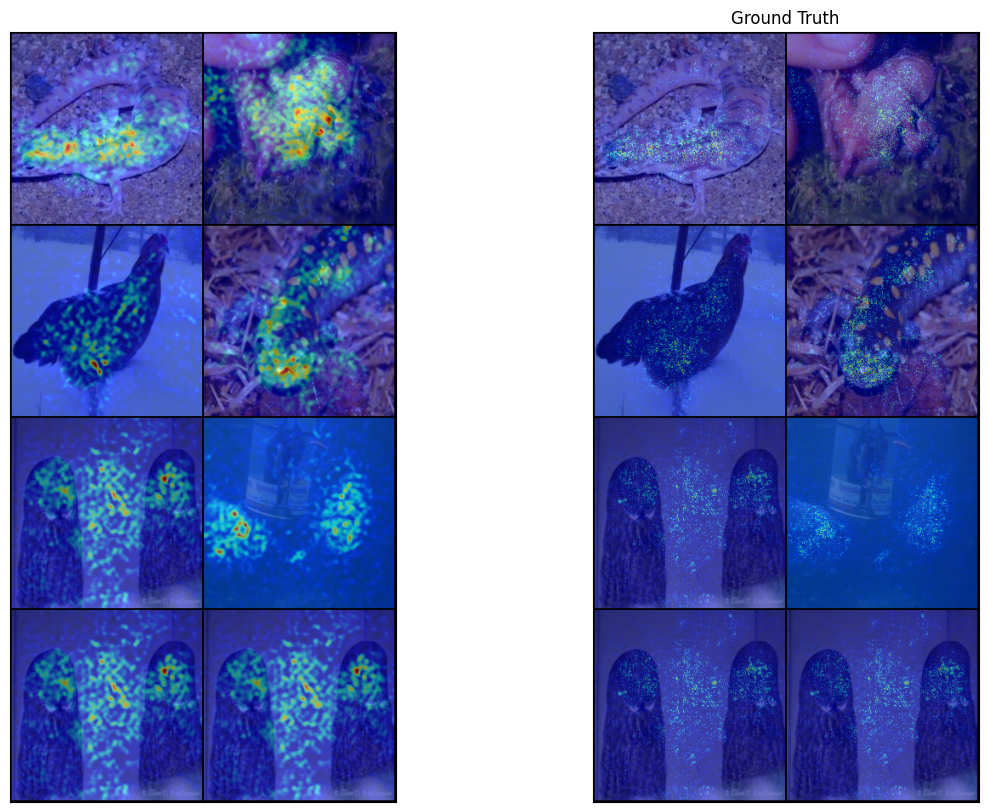

In [200]:
 # Rescale the heatmaps between 0 and 1
rescaled_images = rescale_batch(inputs.detach()).cpu()
rescaled_maps = rescale_batch(computed_maps).cpu()
rescaled_captum_maps = rescale_batch(captum_maps).cpu()
rescaled_gt_maps = rescale_batch(heatmaps).cpu()

# Overlay the heatmaps
overlayed_images = show_cam_on_image(
    rescaled_images, rescaled_maps, use_rgb=True
)

gt_overlayed_images = show_cam_on_image(
    rescaled_images, rescaled_captum_maps, use_rgb=True
)

# Create grid from images
grid = make_grid(
    overlayed_images,
    normalize=False,
    nrow=2,
)

gt_grid = make_grid(
    gt_overlayed_images,
    normalize=False,
    nrow=2,
)

# Permute for numpy format
grid = grid.permute(1, 2, 0)
gt_grid = gt_grid.permute(1, 2, 0)

show_grid(grid, ground_truth=gt_grid)